# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

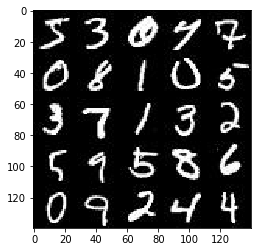

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

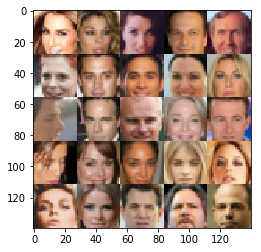

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.0-rc2
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z    = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr         = tf.placeholder(tf.float32, (), name='learning_rate')

    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    drop_rate = 0.5
    size_mult = 64
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        x1 = tf.layers.conv2d(images, size_mult, 5, strides=2, 
                              kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        bn1 = tf.layers.batch_normalization(x1, training=True)
        relu1 = tf.maximum(alpha * bn1, bn1)
        relu1 = tf.layers.dropout(relu1, rate=drop_rate)
        
        x2 = tf.layers.conv2d(relu1, 2 * size_mult, 5, strides=2, 
                              kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        relu2 = tf.layers.dropout(relu2, rate=drop_rate)
        
        x3 = tf.layers.conv2d(relu2, 4 * size_mult, 5, strides=2, 
                              kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.layers.dropout(relu3, rate=drop_rate)
        
        x4 = tf.layers.conv2d(relu3, 8 * size_mult, 5, strides=2, 
                              kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        
        flatten = tf.contrib.layers.flatten(relu4)
        logits = tf.layers.dense(flatten, 1, activation=None)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    size_mult = 64
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2 * 2 * size_mult * 8)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, size_mult * 8))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, size_mult * 4, 5, strides=2, 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, size_mult * 2, 5, strides=2, 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, 
                                            kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # Build the model
    g_model = generator(input_z, out_channel_dim)
    # g_model is the generator output

    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    smooth = 0.1
    
    # Calculate losses
    d_loss_real = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                              labels=tf.ones_like(d_logits_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
                      tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                              labels=tf.zeros_like(d_logits_real)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
                 tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                         labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get the trainable_variables, split into G and D parts
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = beta1).minimize(d_loss, var_list=d_vars)
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    # Create our input placeholders
    input_real, input_z, lr = model_inputs(*data_shape[1:], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[-1])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    n_images = 25
    show_output_step = 100
    print_loss_step = 20
    losses = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                batch_images *= 2
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, 
                                                     input_z: batch_z, 
                                                     lr: learning_rate})
                
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, 
                                                     lr: learning_rate})
                # Run g_train_opt twice
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, 
                                                     lr: learning_rate})
                
                if steps % print_loss_step == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_output_step == 0:
                    show_generator_output(sess, 25, input_z,  data_shape[-1], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.5123... Generator Loss: 0.0540
Epoch 1/2... Discriminator Loss: 1.9419... Generator Loss: 0.2637
Epoch 1/2... Discriminator Loss: 1.0800... Generator Loss: 1.8314
Epoch 1/2... Discriminator Loss: 0.9343... Generator Loss: 1.1654
Epoch 1/2... Discriminator Loss: 1.1282... Generator Loss: 0.9038


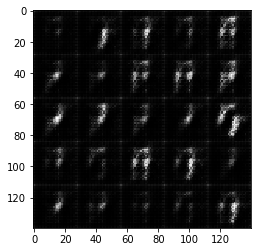

Epoch 1/2... Discriminator Loss: 1.1204... Generator Loss: 1.0145
Epoch 1/2... Discriminator Loss: 1.7453... Generator Loss: 0.4232
Epoch 1/2... Discriminator Loss: 0.9645... Generator Loss: 1.2302
Epoch 1/2... Discriminator Loss: 1.0527... Generator Loss: 1.4650
Epoch 1/2... Discriminator Loss: 1.0621... Generator Loss: 1.1665


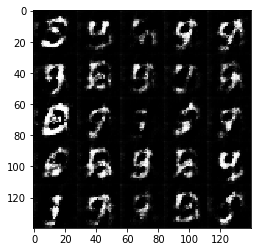

Epoch 1/2... Discriminator Loss: 1.1527... Generator Loss: 1.3193
Epoch 1/2... Discriminator Loss: 1.3881... Generator Loss: 0.6757
Epoch 1/2... Discriminator Loss: 1.1042... Generator Loss: 1.0513
Epoch 1/2... Discriminator Loss: 1.5555... Generator Loss: 0.4698
Epoch 1/2... Discriminator Loss: 1.2271... Generator Loss: 0.7486


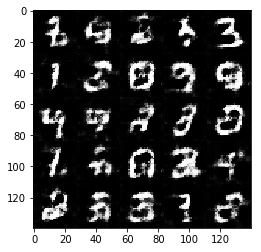

Epoch 1/2... Discriminator Loss: 1.3171... Generator Loss: 1.4834
Epoch 1/2... Discriminator Loss: 1.1576... Generator Loss: 1.2780
Epoch 1/2... Discriminator Loss: 1.2270... Generator Loss: 1.0952
Epoch 1/2... Discriminator Loss: 1.2723... Generator Loss: 0.6264
Epoch 1/2... Discriminator Loss: 1.5817... Generator Loss: 0.4657


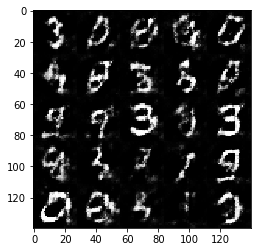

Epoch 1/2... Discriminator Loss: 1.0742... Generator Loss: 1.3370
Epoch 1/2... Discriminator Loss: 1.2049... Generator Loss: 1.0426
Epoch 1/2... Discriminator Loss: 1.1771... Generator Loss: 0.9323
Epoch 1/2... Discriminator Loss: 1.1166... Generator Loss: 0.8375
Epoch 1/2... Discriminator Loss: 1.2045... Generator Loss: 1.3513


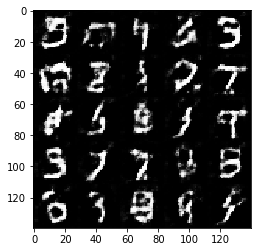

Epoch 1/2... Discriminator Loss: 1.1556... Generator Loss: 0.7924
Epoch 1/2... Discriminator Loss: 1.0215... Generator Loss: 1.3265
Epoch 1/2... Discriminator Loss: 1.4469... Generator Loss: 0.4794
Epoch 1/2... Discriminator Loss: 1.3048... Generator Loss: 0.5934
Epoch 1/2... Discriminator Loss: 0.9962... Generator Loss: 1.0461


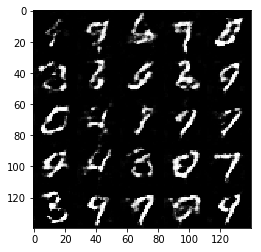

Epoch 1/2... Discriminator Loss: 1.2751... Generator Loss: 0.6198
Epoch 1/2... Discriminator Loss: 1.2854... Generator Loss: 0.6710
Epoch 1/2... Discriminator Loss: 1.1328... Generator Loss: 0.8247
Epoch 1/2... Discriminator Loss: 1.1485... Generator Loss: 0.9798
Epoch 1/2... Discriminator Loss: 1.4530... Generator Loss: 0.4437


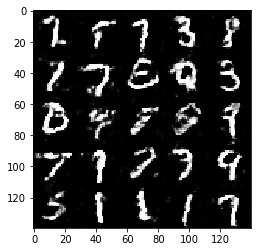

Epoch 1/2... Discriminator Loss: 1.7184... Generator Loss: 0.3516
Epoch 1/2... Discriminator Loss: 1.3321... Generator Loss: 0.5940
Epoch 1/2... Discriminator Loss: 0.9568... Generator Loss: 1.1428
Epoch 1/2... Discriminator Loss: 1.3911... Generator Loss: 0.5146
Epoch 1/2... Discriminator Loss: 1.3539... Generator Loss: 0.5421


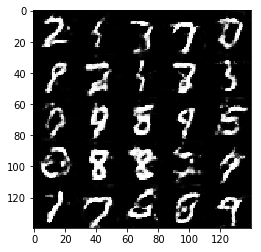

Epoch 1/2... Discriminator Loss: 1.0960... Generator Loss: 0.9435
Epoch 1/2... Discriminator Loss: 1.1974... Generator Loss: 1.4893
Epoch 1/2... Discriminator Loss: 1.4252... Generator Loss: 0.8426
Epoch 1/2... Discriminator Loss: 1.1837... Generator Loss: 0.7144
Epoch 1/2... Discriminator Loss: 1.3476... Generator Loss: 0.5133


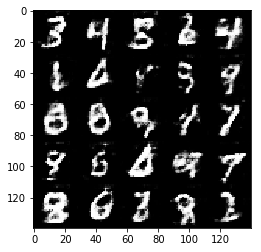

Epoch 1/2... Discriminator Loss: 1.4709... Generator Loss: 0.4359
Epoch 2/2... Discriminator Loss: 1.2029... Generator Loss: 0.6128
Epoch 2/2... Discriminator Loss: 1.3658... Generator Loss: 0.5680
Epoch 2/2... Discriminator Loss: 1.0987... Generator Loss: 0.8235
Epoch 2/2... Discriminator Loss: 1.4224... Generator Loss: 0.4842


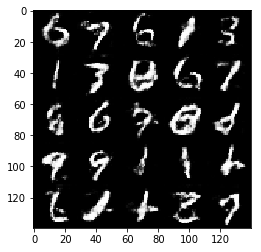

Epoch 2/2... Discriminator Loss: 1.1118... Generator Loss: 0.9178
Epoch 2/2... Discriminator Loss: 1.2813... Generator Loss: 0.5867
Epoch 2/2... Discriminator Loss: 1.0112... Generator Loss: 0.9141
Epoch 2/2... Discriminator Loss: 2.3856... Generator Loss: 0.1746
Epoch 2/2... Discriminator Loss: 1.2255... Generator Loss: 0.6107


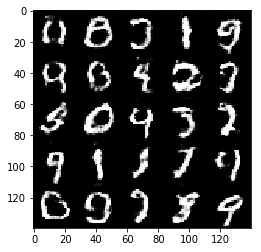

Epoch 2/2... Discriminator Loss: 1.0547... Generator Loss: 0.8059
Epoch 2/2... Discriminator Loss: 1.1013... Generator Loss: 0.8175
Epoch 2/2... Discriminator Loss: 1.6356... Generator Loss: 0.3703
Epoch 2/2... Discriminator Loss: 1.7924... Generator Loss: 0.3100
Epoch 2/2... Discriminator Loss: 0.9745... Generator Loss: 0.9016


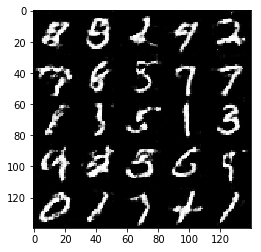

Epoch 2/2... Discriminator Loss: 1.0829... Generator Loss: 0.9149
Epoch 2/2... Discriminator Loss: 1.1598... Generator Loss: 0.6655
Epoch 2/2... Discriminator Loss: 1.0818... Generator Loss: 0.8600
Epoch 2/2... Discriminator Loss: 1.3503... Generator Loss: 0.5569
Epoch 2/2... Discriminator Loss: 1.5106... Generator Loss: 2.8952


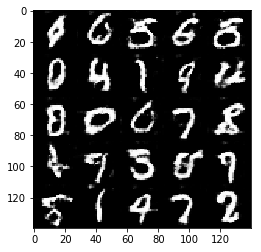

Epoch 2/2... Discriminator Loss: 1.2724... Generator Loss: 0.9934
Epoch 2/2... Discriminator Loss: 1.3395... Generator Loss: 0.5791
Epoch 2/2... Discriminator Loss: 1.2172... Generator Loss: 0.6010
Epoch 2/2... Discriminator Loss: 1.2614... Generator Loss: 1.4238
Epoch 2/2... Discriminator Loss: 1.4386... Generator Loss: 0.5856


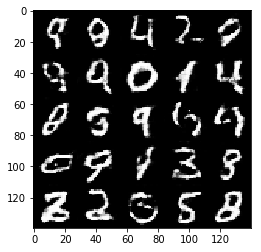

Epoch 2/2... Discriminator Loss: 1.2891... Generator Loss: 0.6559
Epoch 2/2... Discriminator Loss: 1.1785... Generator Loss: 0.6565
Epoch 2/2... Discriminator Loss: 1.6724... Generator Loss: 0.3568
Epoch 2/2... Discriminator Loss: 1.1090... Generator Loss: 0.7445
Epoch 2/2... Discriminator Loss: 0.8927... Generator Loss: 1.1265


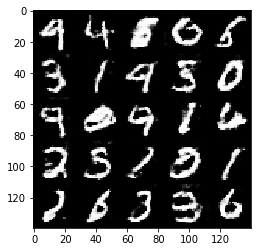

Epoch 2/2... Discriminator Loss: 1.0941... Generator Loss: 0.7077
Epoch 2/2... Discriminator Loss: 0.9249... Generator Loss: 1.0644
Epoch 2/2... Discriminator Loss: 1.3225... Generator Loss: 1.8162
Epoch 2/2... Discriminator Loss: 1.4022... Generator Loss: 0.4828
Epoch 2/2... Discriminator Loss: 1.3861... Generator Loss: 0.5385


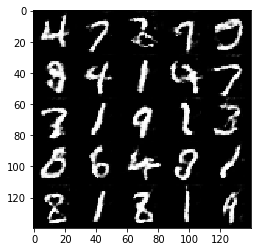

Epoch 2/2... Discriminator Loss: 1.4261... Generator Loss: 0.4778
Epoch 2/2... Discriminator Loss: 1.3021... Generator Loss: 0.6601
Epoch 2/2... Discriminator Loss: 1.1608... Generator Loss: 0.6569
Epoch 2/2... Discriminator Loss: 1.0884... Generator Loss: 1.1366
Epoch 2/2... Discriminator Loss: 1.6685... Generator Loss: 0.3618


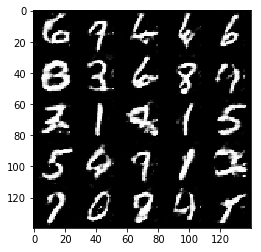

Epoch 2/2... Discriminator Loss: 1.1164... Generator Loss: 0.8604
Epoch 2/2... Discriminator Loss: 1.5362... Generator Loss: 0.4359
Epoch 2/2... Discriminator Loss: 1.3958... Generator Loss: 0.4847
Epoch 2/2... Discriminator Loss: 1.5664... Generator Loss: 0.4870
Epoch 2/2... Discriminator Loss: 1.2498... Generator Loss: 0.7337


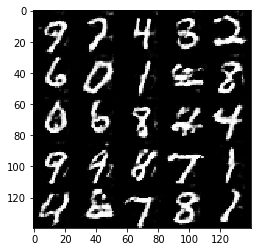

Epoch 2/2... Discriminator Loss: 1.6457... Generator Loss: 0.3946
Epoch 2/2... Discriminator Loss: 1.5684... Generator Loss: 0.4307
Epoch 2/2... Discriminator Loss: 1.1610... Generator Loss: 0.9142


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5592... Generator Loss: 3.5824
Epoch 1/1... Discriminator Loss: 1.0991... Generator Loss: 4.4362
Epoch 1/1... Discriminator Loss: 0.9245... Generator Loss: 1.6659
Epoch 1/1... Discriminator Loss: 1.8146... Generator Loss: 0.7023
Epoch 1/1... Discriminator Loss: 1.5280... Generator Loss: 0.6391


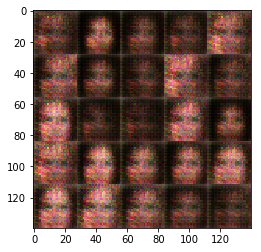

Epoch 1/1... Discriminator Loss: 1.5774... Generator Loss: 0.5927
Epoch 1/1... Discriminator Loss: 1.3503... Generator Loss: 0.7352
Epoch 1/1... Discriminator Loss: 1.5133... Generator Loss: 0.9512
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 0.8400
Epoch 1/1... Discriminator Loss: 1.2676... Generator Loss: 0.7867


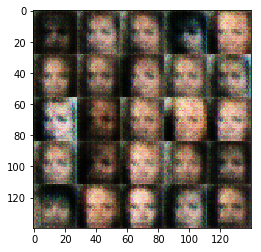

Epoch 1/1... Discriminator Loss: 1.3020... Generator Loss: 0.7775
Epoch 1/1... Discriminator Loss: 1.4920... Generator Loss: 0.5880
Epoch 1/1... Discriminator Loss: 1.4862... Generator Loss: 0.7509
Epoch 1/1... Discriminator Loss: 1.3529... Generator Loss: 0.9154
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.8357


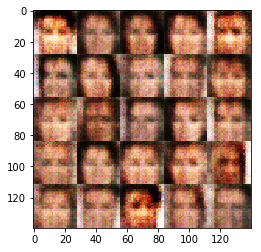

Epoch 1/1... Discriminator Loss: 1.3330... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 1.4132... Generator Loss: 0.7761
Epoch 1/1... Discriminator Loss: 1.5064... Generator Loss: 0.6939
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 1.4504... Generator Loss: 0.7202


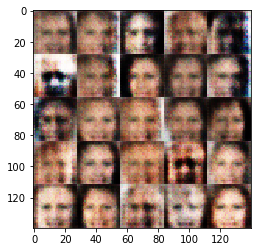

Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.8342
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 1.3449... Generator Loss: 0.8275
Epoch 1/1... Discriminator Loss: 1.3308... Generator Loss: 0.7976
Epoch 1/1... Discriminator Loss: 1.4530... Generator Loss: 0.7425


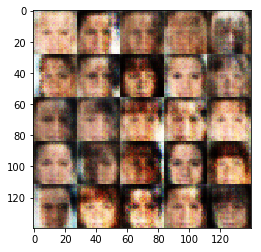

Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 0.8211
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.7432
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.7604
Epoch 1/1... Discriminator Loss: 1.3550... Generator Loss: 0.8170


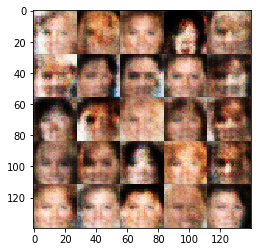

Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.7692
Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 0.7975
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.8121
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.7503
Epoch 1/1... Discriminator Loss: 1.3283... Generator Loss: 0.8018


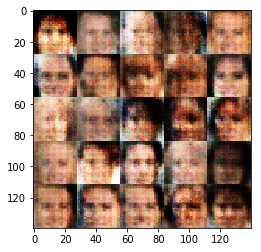

Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.7507
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.7466
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 0.7953


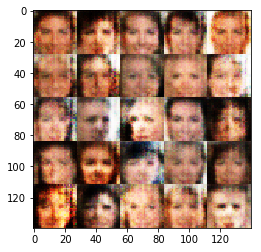

Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.8032
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.7717
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.7914
Epoch 1/1... Discriminator Loss: 1.3547... Generator Loss: 0.8104
Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.7694


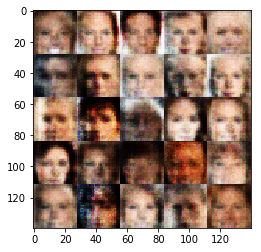

Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.7671
Epoch 1/1... Discriminator Loss: 1.3552... Generator Loss: 0.7823
Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 0.7519
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.7682
Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.8069


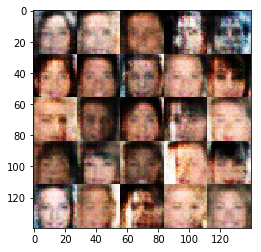

Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.7572
Epoch 1/1... Discriminator Loss: 1.3460... Generator Loss: 0.8067
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.7310
Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.7628
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.7741


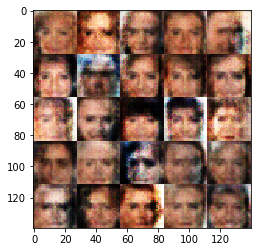

Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.7665
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.7973
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.7417
Epoch 1/1... Discriminator Loss: 1.3365... Generator Loss: 0.7899


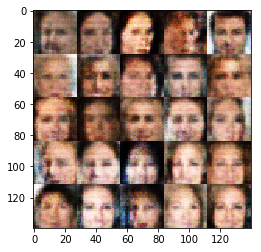

Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.7548
Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.7761
Epoch 1/1... Discriminator Loss: 1.3534... Generator Loss: 0.8002
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.7634
Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 0.7741


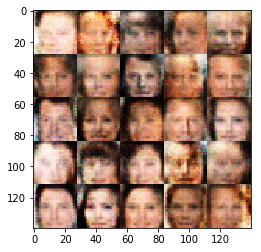

Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.7555
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.7599
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.7639
Epoch 1/1... Discriminator Loss: 1.4357... Generator Loss: 0.7259
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.7751


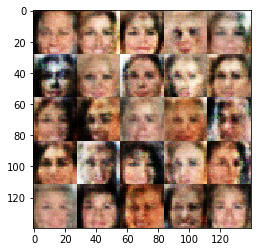

Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.7578
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.7731
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.7523
Epoch 1/1... Discriminator Loss: 1.3392... Generator Loss: 0.8008


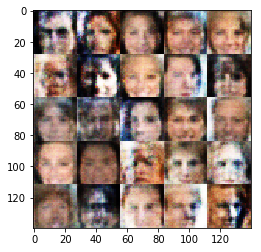

Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.7668
Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.8025
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.7620
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.7993
Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.7835


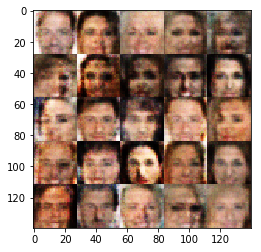

Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 0.7768
Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.7577
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.7590
Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 0.7459
Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.7806


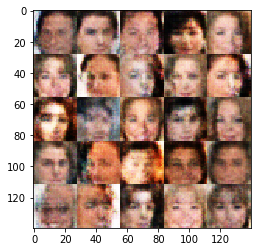

Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.7589
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.7920
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.7772
Epoch 1/1... Discriminator Loss: 1.4508... Generator Loss: 0.7370


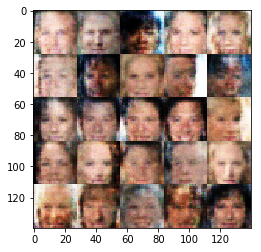

Epoch 1/1... Discriminator Loss: 1.3732... Generator Loss: 0.7668
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.7819
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.8065
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.7827
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.7785


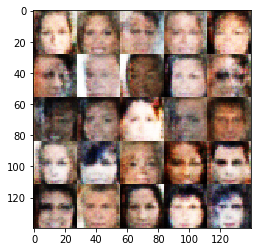

Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.7533
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.7940
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.7691
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.7663
Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.8179


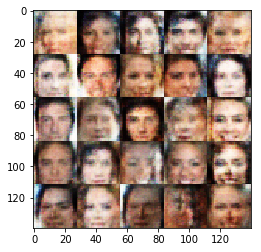

Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 0.7583
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.7723
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.7770
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.7780


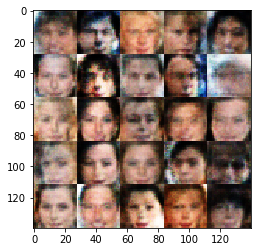

Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.7719
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.7491
Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.7756
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.7505
Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 0.7891


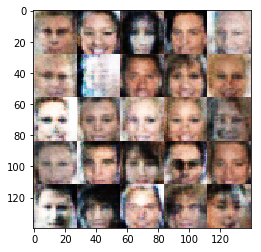

Epoch 1/1... Discriminator Loss: 1.3635... Generator Loss: 0.8082
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.7543
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.7839
Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 0.7653
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.7753


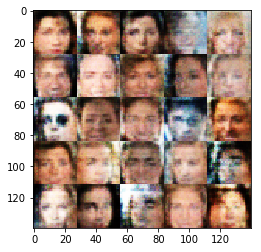

Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.7670
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.7906


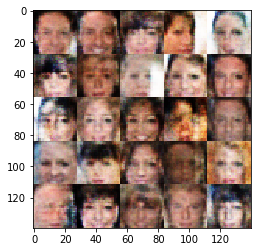

Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.7649
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.7697
Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.7641
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.7609


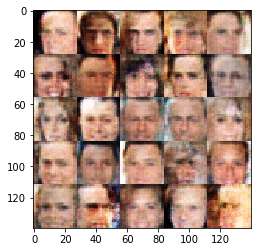

Epoch 1/1... Discriminator Loss: 1.4170... Generator Loss: 0.7484
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.7529
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.7850
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.7647


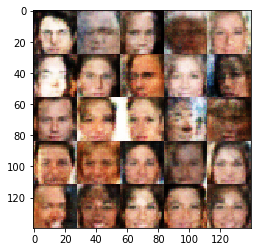

Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.7586
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.8073
Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 0.8104
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.7816
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.7567


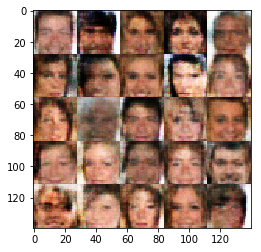

Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.7789
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.8177
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.7517
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.7688
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.7553


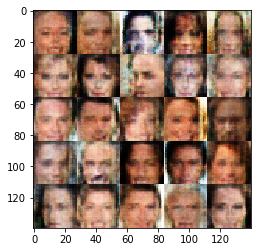

Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.7838
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.7953
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.7895
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.7709


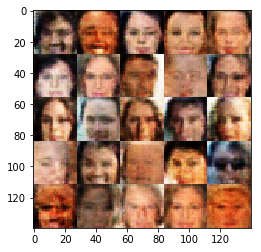

Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.7801
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.7750
Epoch 1/1... Discriminator Loss: 1.3721... Generator Loss: 0.7915
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.7852
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.7779


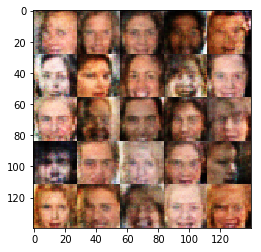

Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.7647
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.7640
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.7644
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.8036
Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 0.7751


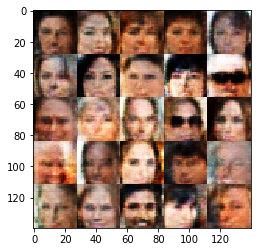

Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.7633
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.7881
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.7862


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.